# Problème 2: Collecte de données Yahoo Finance (2012-2023)



In [19]:
import yfinance as yf
import pandas as pd
import os

def fetch_yahoo_finance(tickers, start='2012-01-03', end='2023-02-01', out_path='yahoo_data.csv'):
    """Télécharge les données Yahoo Finance pour une liste de tickers jusqu'au 3 janvier 2023"""
    
    print(f"Téléchargement de {len(tickers)} titres...")
    all_data = []
    
    for i, ticker in enumerate(tickers):
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(start=start, end=end)
            
            if len(data) > 0:
                # Filtrer jusqu'au 3 janvier 2023 inclus
                data = data[data.index <= '2023-01-03']
                
                data = data[['Close']].copy()
                data.reset_index(inplace=True)
                data['ticker'] = ticker
                data.columns = ['date', 'adj_close', 'ticker']
                #calcul des rendements
                data['returns'] = data['adj_close'].pct_change()
                data = data[['date', 'ticker', 'adj_close', 'returns']]
                all_data.append(data)
                
        except Exception as e:
            print(f"Erreur pour {ticker}: {e}")
    
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
        df.to_csv(out_path, index=False)
        print(f"Données sauvegardées: {len(df):,} observations")
        return df
    else:
        print("Aucune donnée récupérée")
        return pd.DataFrame()

In [20]:
# Liste complète des 10 titres requis (mêmes que CRSP mais avec tickers Yahoo)
tickers_yahoo = [
    # INDICE DE MARCHÉ
    'SPY',              # SPDR S&P 500 ETF Trust
    
    # SECTEUR FINANCIER
    'EFX',              # Equifax Inc. 
    'JPM',              # JPMorgan Chase & Co.
    'GNW',              # Genworth Financial Inc.
    
    # SECTEUR TECHNOLOGIQUE
    'EA',               # Electronic Arts Inc.
    'JBL',              # Jabil Inc.
    'GOOGL',            # Alphabet Inc. (Class A)
    
    # SECTEUR ÉNERGÉTIQUE
    'EOG',              # EOG Resources Inc.
    'JKS',              # JinkoSolar Holding Co.
    'GTE',              # Gran Tierra Energy Inc.
]

# Mapping pour organisation par secteur
secteurs_mapping = {
    'SPY': 'Indice de marché',
    'EFX': 'Secteur financier', 'JPM': 'Secteur financier', 'GNW': 'Secteur financier',
    'EA': 'Secteur technologique', 'JBL': 'Secteur technologique', 'GOOGL': 'Secteur technologique',
    'EOG': 'Secteur énergétique', 'JKS': 'Secteur énergétique', 'GTE': 'Secteur énergétique'
}

In [21]:
# TÉLÉCHARGEMENT ET ORGANISATION DES DONNÉES

# Vérifier si on a tous les 10 titres requis ET la bonne période
if os.path.exists('donnees_yahoo_probleme2.csv'):
    df_temp = pd.read_csv('donnees_yahoo_probleme2.csv')
    df_temp['date'] = pd.to_datetime(df_temp['date'], utc=True)
    tickers_existants = df_temp['ticker'].unique()
    date_max = df_temp['date'].max().date()
    
    # Vérifier 10 titres ET période jusqu'au 3 janvier 2023
    if (len(tickers_existants) == 10 and 
        all(ticker in tickers_existants for ticker in tickers_yahoo) and
        date_max >= pd.to_datetime('2023-01-03').date()):
        df = df_temp.copy()
    else:
        df = fetch_yahoo_finance(tickers_yahoo, out_path='donnees_yahoo_probleme2.csv')
else:
    df = fetch_yahoo_finance(tickers_yahoo, out_path='donnees_yahoo_probleme2.csv')

# Ajouter la colonne secteur et organiser les données
df['secteur'] = df['ticker'].map(secteurs_mapping)
df = df[['date', 'ticker', 'secteur', 'adj_close', 'returns']]

# Créer les fichiers individuels
os.makedirs('donnees_individuelles_yahoo', exist_ok=True)
for ticker in tickers_yahoo:
    fichier = f'donnees_individuelles_yahoo/{ticker}.csv'
    data_ticker = df[df['ticker'] == ticker]
    data_ticker.to_csv(fichier, index=False)

# RÉSUMÉ DES DONNÉES
print(f"\nStructure: {df.shape[0]:,} observations, {df.shape[1]} colonnes")
print(f"Période: {df['date'].min().date()} à {df['date'].max().date()}")

print(f"\nObservations par titre:")
obs_par_titre = df.groupby(['ticker', 'secteur']).size().reset_index(name='observations')
for _, row in obs_par_titre.iterrows():
    print(f"  {row['ticker']} ({row['secteur']}): {row['observations']:,} obs")


Structure: 27,690 observations, 5 colonnes
Période: 2012-01-03 à 2023-01-03

Observations par titre:
  EA (Secteur technologique): 2,769 obs
  EFX (Secteur financier): 2,769 obs
  EOG (Secteur énergétique): 2,769 obs
  GNW (Secteur financier): 2,769 obs
  GOOGL (Secteur technologique): 2,769 obs
  GTE (Secteur énergétique): 2,769 obs
  JBL (Secteur technologique): 2,769 obs
  JKS (Secteur énergétique): 2,769 obs
  JPM (Secteur financier): 2,769 obs
  SPY (Indice de marché): 2,769 obs


# Problème 2(a): Statistiques descriptives et graphiques des rendements



In [24]:
# Importer les librairies pour les graphiques et statistiques
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Configuration des graphiques
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Supprimer les valeurs manquantes pour les calculs
df_clean = df.dropna(subset=['returns'])

print("=== STATISTIQUES DESCRIPTIVES DES RENDEMENTS ===\n")

# Calculer les statistiques descriptives par titre
stats_summary = []

for ticker in tickers_yahoo:
    data_ticker = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    stats_dict = {
        'Ticker': ticker,
        'Secteur': secteur,
        'Observations': len(data_ticker),
        'Moyenne': data_ticker.mean(),
        'Écart-type': data_ticker.std(),
        'Minimum': data_ticker.min(),
        'Maximum': data_ticker.max(),
        'Médiane': data_ticker.median(),
        'Asymétrie': stats.skew(data_ticker),
        'Kurtosis': stats.kurtosis(data_ticker),
        'Jarque-Bera': stats.jarque_bera(data_ticker)[0],
        'JB p-value': stats.jarque_bera(data_ticker)[1]
    }
    stats_summary.append(stats_dict)
    
    # Afficher les statistiques pour chaque titre
    print(f"{ticker} ({secteur}):")
    print(f"  Observations: {stats_dict['Observations']:,}")
    print(f"  Moyenne: {stats_dict['Moyenne']:.6f} ({stats_dict['Moyenne']*252:.4f} annualisé)")
    print(f"  Écart-type: {stats_dict['Écart-type']:.6f} ({stats_dict['Écart-type']*np.sqrt(252):.4f} annualisé)")
    print(f"  Min/Max: {stats_dict['Minimum']:.6f} / {stats_dict['Maximum']:.6f}")
    print(f"  Asymétrie: {stats_dict['Asymétrie']:.4f}")
    print(f"  Kurtosis: {stats_dict['Kurtosis']:.4f}")
    print(f"  Jarque-Bera: {stats_dict['Jarque-Bera']:.2f} (p-value: {stats_dict['JB p-value']:.4f})")
    print()

# Créer un DataFrame des statistiques pour comparaison
stats_df = pd.DataFrame(stats_summary)
print("=== TABLEAU COMPARATIF DES STATISTIQUES ===")
print(stats_df.round(6).to_string(index=False))

=== STATISTIQUES DESCRIPTIVES DES RENDEMENTS ===

SPY (Indice de marché):
  Observations: 2,768
  Moyenne: 0.000528 (0.1331 annualisé)
  Écart-type: 0.010715 (0.1701 annualisé)
  Min/Max: -0.109423 / 0.090603
  Asymétrie: -0.5569
  Kurtosis: 13.4798
  Jarque-Bera: 21099.87 (p-value: 0.0000)

EFX (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000778 (0.1961 annualisé)
  Écart-type: 0.016837 (0.2673 annualisé)
  Min/Max: -0.147798 / 0.149406
  Asymétrie: -0.2903
  Kurtosis: 12.4243
  Jarque-Bera: 17842.01 (p-value: 0.0000)

JPM (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000743 (0.1872 annualisé)
  Écart-type: 0.016969 (0.2694 annualisé)
  Min/Max: -0.149649 / 0.180125
  Asymétrie: 0.2647
  Kurtosis: 13.0157
  Jarque-Bera: 19570.72 (p-value: 0.0000)

GNW (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000511 (0.1288 annualisé)
  Écart-type: 0.034639 (0.5499 annualisé)
  Min/Max: -0.384506 / 0.276364
  Asymétrie: -0.0719
  Kurtosis: 16.4978
  Jarque-Bera: 3139


=== GRAPHIQUES DES SÉRIES CHRONOLOGIQUES ===



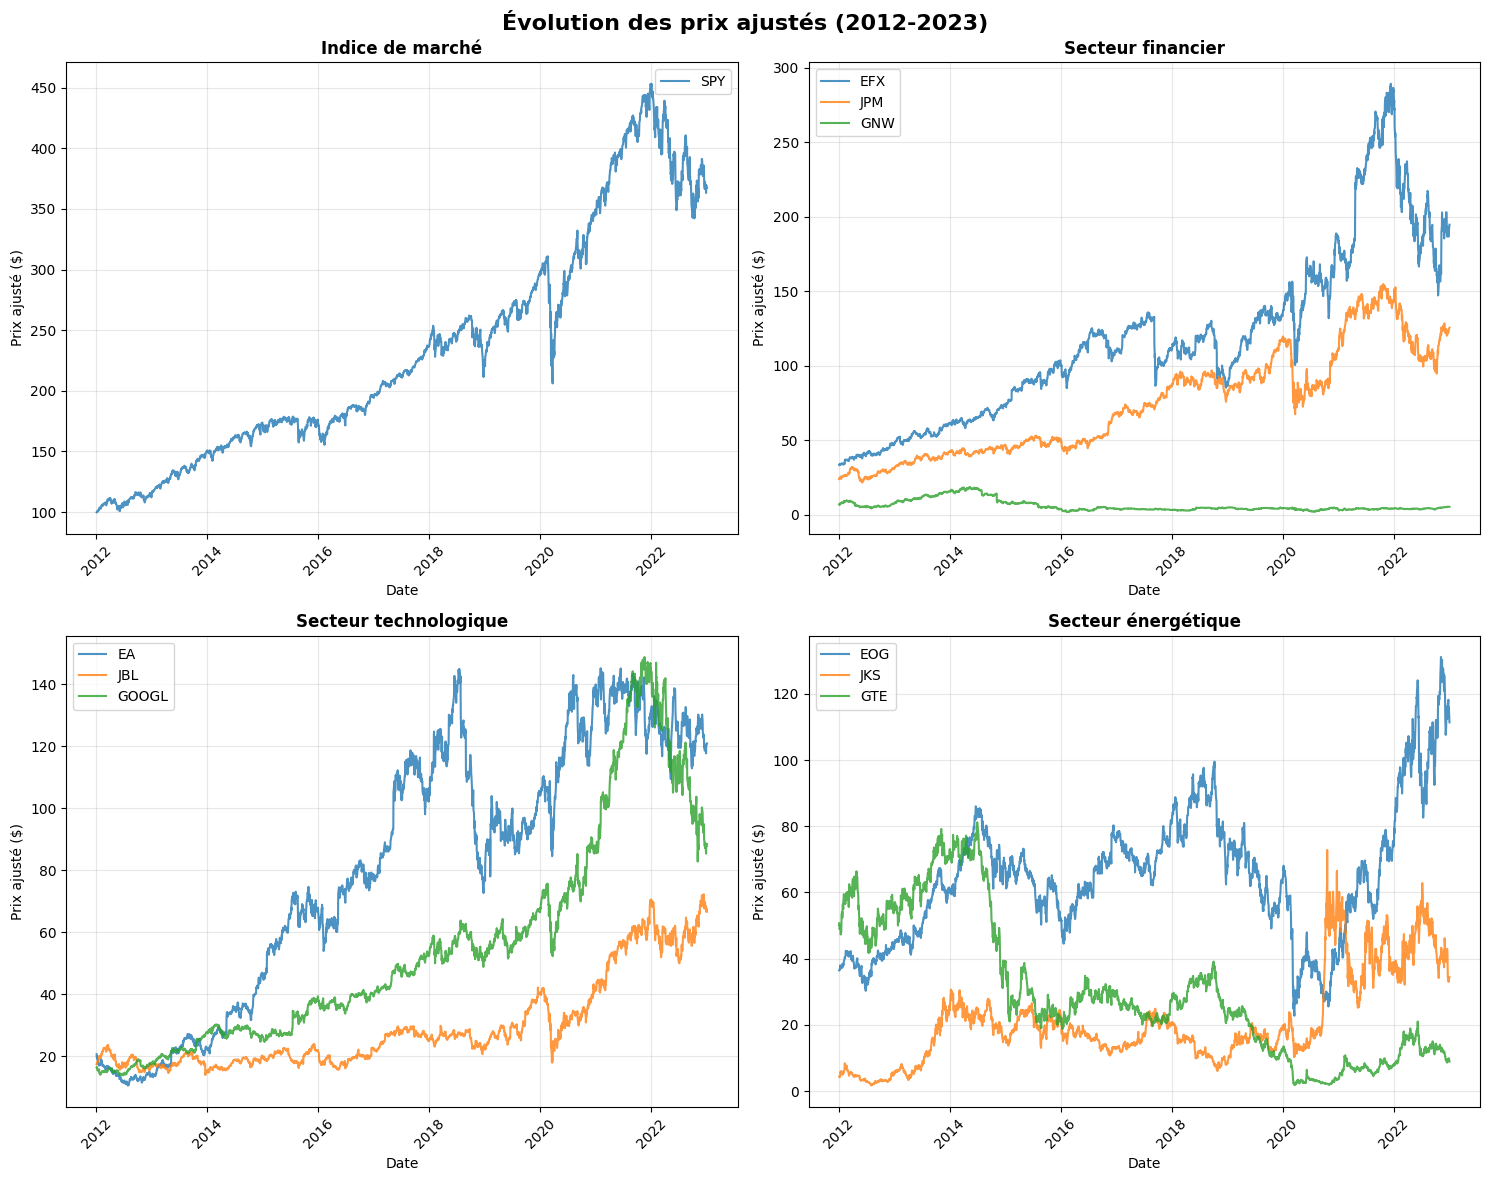

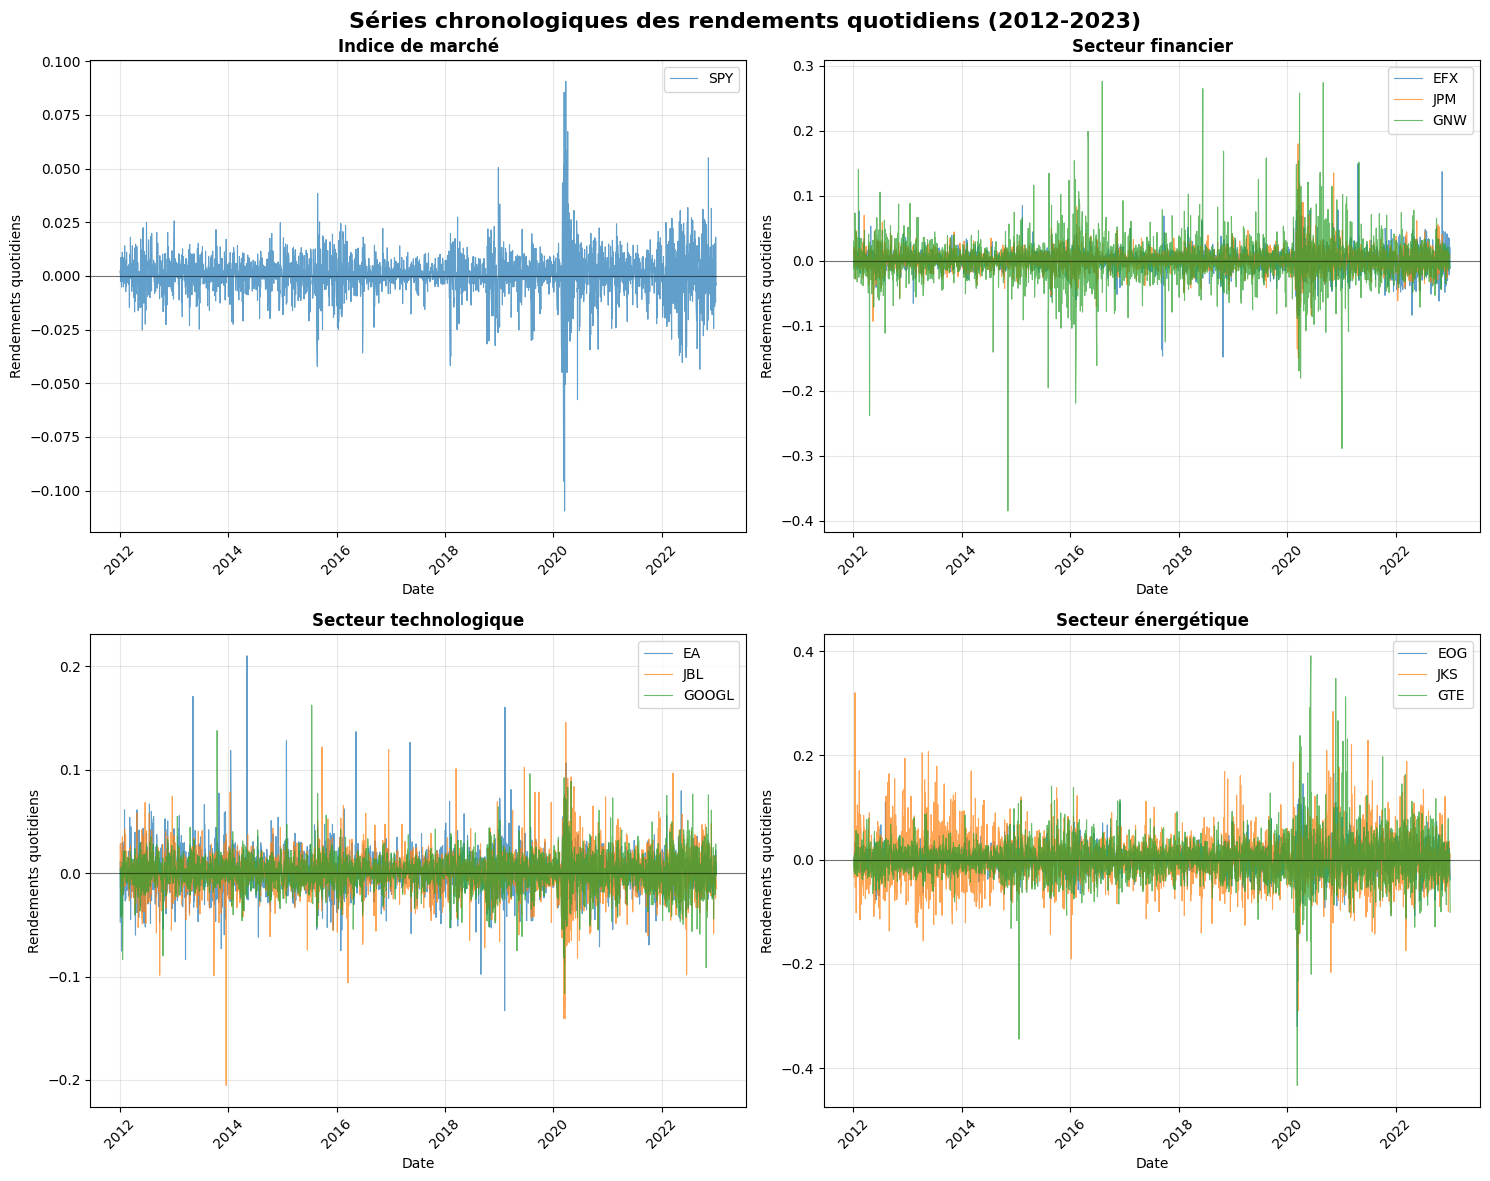

In [25]:
# GRAPHIQUES DES SÉRIES CHRONOLOGIQUES DES PRIX
print("\n=== GRAPHIQUES DES SÉRIES CHRONOLOGIQUES ===\n")

# 1. Graphique des prix ajustés
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Évolution des prix ajustés (2012-2023)', fontsize=16, fontweight='bold')

# Organiser par secteur
secteurs = ['Indice de marché', 'Secteur financier', 'Secteur technologique', 'Secteur énergétique']
colors = ['blue', 'green', 'red', 'orange']

for i, secteur in enumerate(secteurs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    tickers_secteur = [t for t in tickers_yahoo if secteurs_mapping[t] == secteur]
    
    for ticker in tickers_secteur:
        data_ticker = df[df['ticker'] == ticker]
        ax.plot(data_ticker['date'], data_ticker['adj_close'], 
                label=ticker, linewidth=1.5, alpha=0.8)
    
    ax.set_title(f'{secteur}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Prix ajusté ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Graphique des rendements
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Séries chronologiques des rendements quotidiens (2012-2023)', fontsize=16, fontweight='bold')

for i, secteur in enumerate(secteurs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    tickers_secteur = [t for t in tickers_yahoo if secteurs_mapping[t] == secteur]
    
    for ticker in tickers_secteur:
        data_ticker = df_clean[df_clean['ticker'] == ticker]
        ax.plot(data_ticker['date'], data_ticker['returns'], 
                label=ticker, linewidth=0.8, alpha=0.7)
    
    ax.set_title(f'{secteur}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rendements quotidiens')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()